# Heart Disease Prediction

A heart disease data exploration and prediction notebook. Explore the heart disease data from https://archive.ics.uci.edu/ml/datasets/Heart+Disease. Find patterns in data and sort out the conditions in record that may result in heart disease and find out which group of people are likely to have a higher percentage of having a heart disease. At last build different machine learning models that predict whether a patient is affected by a heart disease, evalutate and improve them and find a model that best fits the usecase.


## 1. Problem Definition

Given, the records of patients with certain medical measurements, try to predict whether a patient has a heart disease or not. **(Binary - Classification)**

## 2. Import Tools

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV

from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score, plot_roc_curve, confusion_matrix

## 3. Data
Source: https://archive.ics.uci.edu/ml/datasets/Heart+Disease

The original data came from the Cleveland database from UCI Machine Learning Repository.

Howevever, we've downloaded it in a formatted way from Kaggle.

The original database contains 76 attributes, but here only 14 attributes will be used. Attributes (also called features) are the variables what we'll use to predict our target variable.

### Load Data

In [2]:
df = pd.read_csv('data/heart-disease.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


### Data Dictionary

The features used to predict the target variable **Heart Disease: yes or no**

1. **age** - age in years
2. **sex** - (1 = male; 0 = female)
3. **cp** - chest pain type (4 values):
    1. Typical angina: chest pain related decrease blood supply to the heart
    2. Atypical angina: chest pain not related to heart
    3. Non-anginal pain: typically esophageal spasms (non heart related)
    4. Asymptomatic: chest pain not showing signs of disease
4. **trestbps** - resting blood pressure
5. **chol** - serum cholestoral in mg/dl
6. **fbs** - fasting blood sugar > 120 mg/dl
7. **restecg** - resting electrocardiographic results (values 0,1,2)
8. **thalach** - maximum heart rate achieved
9. **exang** - exercise induced angina
10. **oldpeak** - ST depression induced by exercise relative to rest
11. **slope** - the slope of the peak exercise ST segment
12. **ca** - number of major vessels (0-3) colored by flourosopy
13. **thal** - thalium stress result: 
    1. 3 - normal
    2. 6 - fixed defect
    3. 7 - reversable defect

## 4. Exploratory Data Analysis

In [4]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


### Dataset Balance

<BarContainer object of 2 artists>

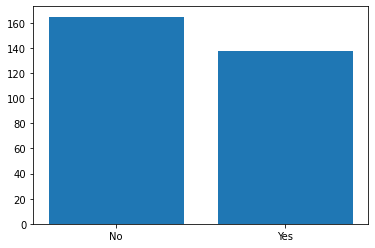

In [5]:
fig, ax = plt.subplots()
ax.bar(["No","Yes"],df["target"].value_counts())

The dataset here is balanced one eventhough there is a **slight baised towards "NO"**

### Correlation Matrix

<AxesSubplot:>

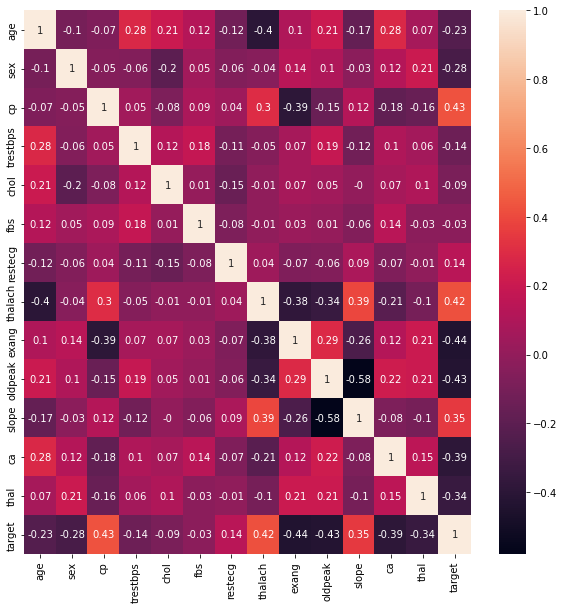

In [6]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(df.corr().round(decimals=2),annot=True) 

In [16]:
# Remove columns with low correlation
df_dropped = df.drop("chol",axis=1)

Dropped the column **chol** which has a very low correlation of ***0.09***.

### Outliers

<AxesSubplot:xlabel='oldpeak'>

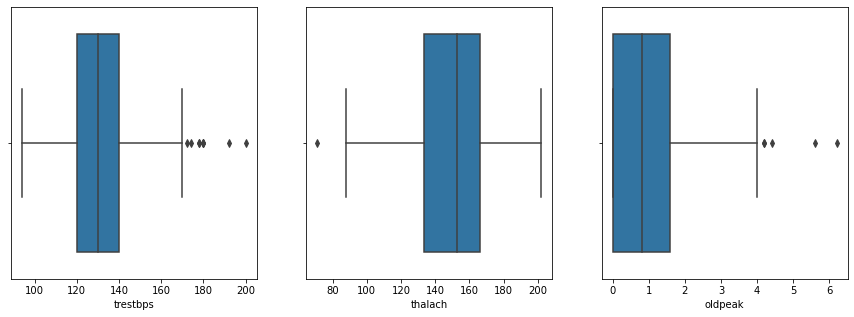

In [8]:
fig, ax = plt.subplots(ncols=3,figsize=(15,5))
sns.boxplot(x=df["trestbps"],ax=ax[0])
sns.boxplot(x=df["thalach"],ax=ax[1])
sns.boxplot(x=df["oldpeak"],ax=ax[2])

In [17]:
# Removing outliers
df_dropped.drop(df[df.trestbps > 190].index, inplace=True)
df_dropped.drop(df[df.thalach < 80].index, inplace=True)
df_dropped.drop(df[df.oldpeak > 5].index, inplace=True)

### Linear Separability

In [21]:
svc = SVC(C=2**32)
svc.fit(df_dropped.drop("target",axis=1),df_dropped["target"])

SVC(C=4294967296)

In [22]:
svc.score(df_dropped.drop("target",axis=1),df_dropped["target"])

0.8859060402684564

Since our SVM cannot fit the data to 100 percent accuracy, the data we have is linearly inseparable.

## 5. Modelling

In [29]:
# Splitting Data
X_train, X_test, y_train, y_test = train_test_split(df_dropped.drop("target",axis=1),
                                                    df_dropped["target"],
                                                    test_size=0.2)

In [30]:
model_dict = {
    "ridge": RidgeClassifier(),
    "logistic": LogisticRegression(),
    "randomforest": RandomForestClassifier(),
    "gradientboosting": GradientBoostingClassifier(),
    "KNN": KNeighborsClassifier()
}

In [39]:
# Train diff models
def train_models():
    for i in model_dict.keys():
        model_dict[i].fit(X_train, y_train)
        
# Score models
model_scores_dict={}

def score_models():
    for i in model_dict.keys():
        model_scores_dict[i] = model_dict[i].score(X_test, y_test)        

In [36]:
train_models()

C:\Users\Arun\Documents\project-heart-disease\env\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [40]:
score_models()
print(model_scores_dict)

{'ridge': 0.8666666666666667, 'logistic': 0.9, 'randomforest': 0.8333333333333334, 'gradientboosting': 0.8166666666666667, 'KNN': 0.6333333333333333}
